### Imports

In [95]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": "Times New Roman",
})

### Defining parameters

In [96]:
# Set the initial conditions
q0 = 1.0       # initial position
p0 = 0.0       # initial momentum

# Set the simulation parameters
dt_leap = 0.1       # stepsize
dt_euler = 0.011
t_max = 10.0   # maximum simulation time
m = 1
K = 1

### Hamiltonian dynamics for harmonic oscillator

In [97]:
def hamiltonian_dynamics(p, q): # for harmonic oscillator (991) and (992) in optimization
    return np.array([p/m, -K*q])

def gradient_potenital_energy(q): 
    return K*q

#### Leapfrog method

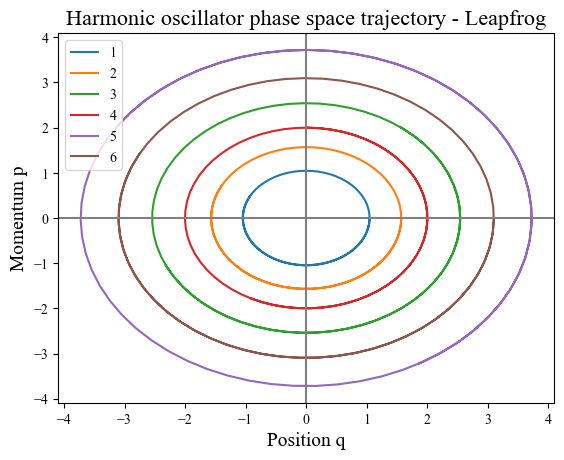

In [108]:
# Define the Leapfrog integrator
def leapfrog(q, p, dt):
    p_half = p - 0.5*dt*gradient_potenital_energy(q)
    q_next = q + dt*p_half
    p_next = p_half - 0.5*dt*gradient_potenital_energy(q_next)
    return q_next, p_next

def generate_trajectory(q0, p0):
    # Initialize the trajectory arrays
    t_leapfrog = np.arange(0, t_max, dt_leap)
    q_leapfrog = np.zeros_like(t_leapfrog)
    p_leapfrog = np.zeros_like(t_leapfrog)

    # Set the initial values
    q_leapfrog[0] = q0
    p_leapfrog[0] = p0

    # Run the simulation using the Leapfrog integrator
    for i in range(1, len(t_leapfrog)):
        q_leapfrog[i], p_leapfrog[i] = leapfrog(q_leapfrog[i-1], p_leapfrog[i-1], dt_leap)

    return q_leapfrog, p_leapfrog

init_conditions = [[np.pi/3, 0], [np.pi/2, 0], [np.pi/2, 2], [0, 2], [-np.pi, 2], [3.1, 0]]
q_leapfrog = []
p_leapfrog = []
legend = []

for i in range(len(init_conditions)):
    q, p = generate_trajectory(init_conditions[i][0], init_conditions[i][1])
    q_leapfrog.append(q)
    p_leapfrog.append(p)

# Plot the trajectory in phase space
for i in range(len(q_leapfrog)):
    plt.plot(q_leapfrog[i], p_leapfrog[i])
    legend.append(str(i+1))

plt.xlabel('Position q', fontsize = 14)
plt.ylabel('Momentum p', fontsize = 14)
plt.axhline(y=0, color='grey')
plt.axvline(x=0, color='grey')
#plt.xlim((-5, 5))
#plt.ylim((-7, 7))
plt.legend(legend, loc = "upper left" , frameon = True , prop ={'size': 10 } )
plt.title('Harmonic oscillator phase space trajectory - Leapfrog', fontsize=16)
plt.show()

#### Explicit Euler

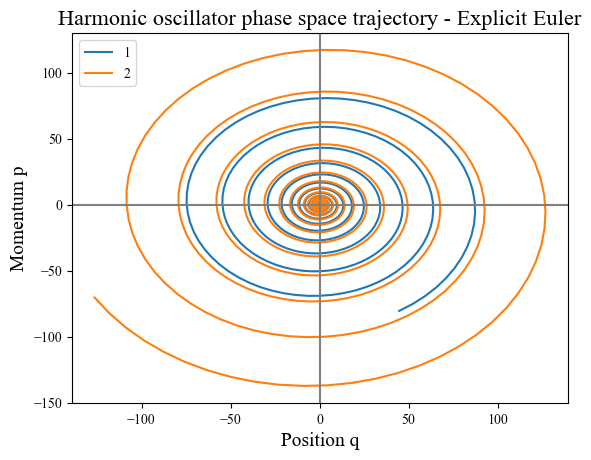

In [105]:
# Based on eurlers method in MCMC using hamiltonian dynamics
def explicit_euler(p, q, dt):
    p_next = p - dt * gradient_potenital_energy(q) # update position
    q_next = q + dt * p/m # update momentum
    return q_next, p_next

def generate_trajectory_euler(q0, p0):
    # Initialize the trajectory arrays
    t_euler = np.arange(0, t_max, dt_euler)
    q_euler = np.zeros_like(t_euler)
    p_euler = np.zeros_like(t_euler)

    # Set the initial values
    q_euler[0] = q0
    p_euler[0] = p0

    # Run the simulation using the Leapfrog integrator
    for i in range(1, len(t_euler)):
        q_euler[i], p_euler[i] = explicit_euler(p_euler[i-1], q_euler[i-1], dt_leap)

    return q_euler, p_euler

#init_conditions_euler = [[np.pi/3, 0], [np.pi/2, 0], [np.pi, -3], [np.pi/2, 2], [0, 2], [2, 0], [-np.pi, 3], [3.1, 0]]
init_conditions_euler = [[0, 1], [np.pi/2, 0]]
q_euler = []
p_euler = []
legend_euler = []

for i in range(len(init_conditions_euler)):
    q, p = generate_trajectory_euler(init_conditions_euler[i][0], init_conditions_euler[i][1])
    q_euler.append(q)
    p_euler.append(p)

# Plot the trajectory in phase space
for i in range(len(q_euler)):
    plt.plot(q_euler[i], p_euler[i])
    legend_euler.append(str(i+1))

# Plot the trajectory in phase space
plt.xlabel('Position q', fontsize = 14)
plt.ylabel('Momentum p', fontsize = 14)
plt.axhline(y=0, color='grey')
plt.axvline(x=0, color='grey')
plt.legend(legend_euler, loc = "upper left" , frameon = True , prop ={'size': 10 } )
plt.title('Harmonic oscillator phase space trajectory - Explicit Euler', fontsize=16)
plt.show()